In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')
df_train.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.62,808.5,367.5,220.5,3.5,3,0.10,5,12.74
1,0.90,563.5,318.5,122.5,7.0,3,0.10,2,29.68
2,0.90,563.5,318.5,122.5,7.0,3,0.40,2,36.57
3,0.79,637.0,343.0,147.0,7.0,2,0.25,2,38.57
4,0.90,563.5,318.5,122.5,7.0,4,0.40,5,34.72


In [2]:
x_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1]
x_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]
type(x_train)

pandas.core.frame.DataFrame

In [3]:
def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

In [4]:
x_train, _, _ = normalize(x_train)
x_test, _, _ = normalize(x_test)

In [5]:
x_train['bias'] = [1]*x_train.shape[0]
x_test['bias'] = [1]*x_test.shape[0]
x_train.shape, x_test.shape

((384, 9), (384, 9))

In [6]:
import CM50268_CW2_setup as lab2
import CM50268_CW1_Setup as lab1

In [7]:
x_train = x_train.iloc[:,:].values#.reshape(-1,1)
x_test = x_test.iloc[:,:].values#.reshape(-1,1)

x_train.shape

(384, 9)

In [8]:
PHI_train = x_train#basis.evaluate(x_train)
PHI_test = x_test #basis.evaluate(x_test)

In [9]:
def fit_pls(PHI, y, lam):
    
    n_cols = PHI.shape[1]
            
    print(PHI.shape)
    w = np.linalg.lstsq(PHI.T.dot(PHI) \
                        + lam * np.identity(n_cols), 
                        PHI.T.dot(y),
                        rcond = -1)
    
    return w

In [10]:
def approxData_test(PHI_test,PHI_train, y_train,lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    W = fit_pls(PHI_train, y_train, lam)
    prediction = PHI_test.dot(W[0])
    
    return prediction
    
## GRAPHING FUNCTION 
#  
def plot_regression(approxData_test, x_train, y_train, x_test, y_test, lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    
    plt.plot(x_test, approxData_test, label = 'predicted', alpha = 0.3)
    plt.scatter(x_test, y_test, label = 'test data', 
            marker = 'x', alpha = 0.3)
    plt.scatter(x_train, y_train, label = 'train data',
               color = 'black', marker = '*', alpha = 0.3)
    plt.title('Lambda = {:.5f}'.format(lam))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [11]:
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    n_cols = PHI.shape[1]
    Mu = np.linalg.lstsq(PHI.T.dot(PHI) \
                        + s2 * alph * np.eye(n_cols), 
                        PHI.T.dot(y),
                        rcond = -1)[0]
    
    SIGMA = s2 * np.linalg.inv(PHI.T.dot(PHI) + s2*alph*np.eye(n_cols))
    
    return Mu, SIGMA

In [12]:
alph = 1e-4
s2 = 1e-3

#alpha = 0.0000141747
#s2 = 174.7528400008

Mu, SIGMA= compute_posterior(PHI_train, y_train, alph, s2)


y_post_train = PHI_train.dot(Mu)
y_post = PHI_test.dot(Mu)


var_matrix = np.diag(s2 + PHI_test.dot(SIGMA).dot(PHI_test.T))
upper_bound =  (y_post.reshape(384) + 1 * np.sqrt(var_matrix))
lower_bound =  (y_post.reshape(384) - 1 * np.sqrt(var_matrix))


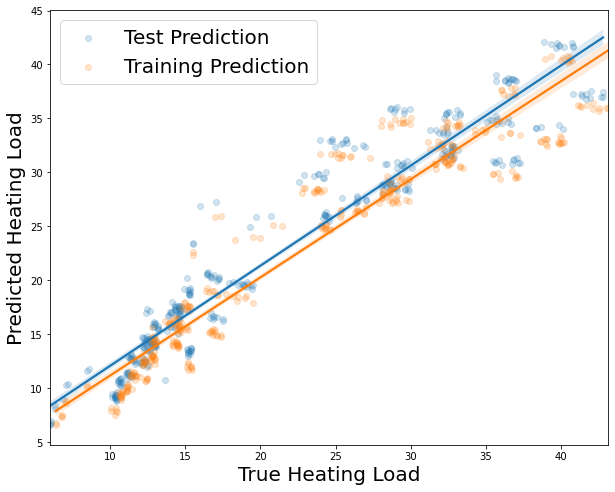

In [13]:
import seaborn as sns
sns.regplot(y_test,y_post, label = 'Test Prediction',scatter_kws={'alpha':0.2})
sns.regplot(y_train,y_post_train, label = 'Training Prediction',scatter_kws={'alpha':0.2})
plt.xlabel('True Heating Load', size = 20)
plt.ylabel('Predicted Heating Load', size = 20)
plt.legend(fontsize = 20)

In [14]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as MSE

r2(y_test,y_post), np.sqrt(MSE(y_test,y_post))

(0.9056119420621269, 3.0958866024599505)

In [15]:
alph = 1e-4
s2 = 1e-3
def log_prob_alph_r_given_y(alph, s2, x, y):
    
    PHI = x #RBF.evaluate(x)
    
    return lab2.compute_log_marginal(PHI, y, alph, s2)

In [16]:
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    n, m = PHI.shape
    
    Mu, SIGMA = compute_posterior(PHI, y, alph, s2)
    
    y = y.reshape(-1,1)
    
    cov = s2*np.eye(n) + ((1/alph) * PHI.dot(PHI.T) )
    
    lgp = ((2*np.pi) ** (-n/2)) * \
            (np.linalg.det(cov))**-0.5 * \
            np.exp( np.matmul( -0.5*y.T, np.matmul( np.linalg.inv( cov ), y ) ) )
      
             
    return np.log(lgp)

In [17]:
t = log_prob_alph_r_given_y(1e-3, s2, x_train, y_train.values)

In [18]:
x_train.shape

(384, 9)

In [19]:
r = 1
s2 = 0.001

In [20]:
alpha_space = np.linspace(-8,-2, 100) # -8, 0
radius_space = np.linspace(1, 4, 100) # 1, 4

store_alph = []
store_rad = []
store_log_prob_y= []
store_prob_y = []

logpy = np.ndarray((len(alpha_space), len(radius_space)))
py = np.ndarray((len(alpha_space), len(radius_space)))


for i, ax in enumerate(alpha_space):
    for j, rx in enumerate(radius_space):
        
        alph = np.exp(ax)
        s2 = np.exp(rx)
        
        #print(rx, ax)
        
        log_prob_y = log_prob_alph_r_given_y(alph, s2, x_train, y_train.values)
        #log_prob_y = compute_log_marginal(x_train, y_train.values, alph, s2)
        prob_y = np.exp(log_prob_y)
        
        store_alph.append(ax)
        store_rad.append(rx)
        
        store_log_prob_y.append(log_prob_y)
        store_prob_y.append(prob_y)
        
        logpy[j][i] = log_prob_y
        py[j][i] = prob_y

In [21]:
logpy.min(), logpy.max()

(-1254.7392499188065, -1001.4669784956466)

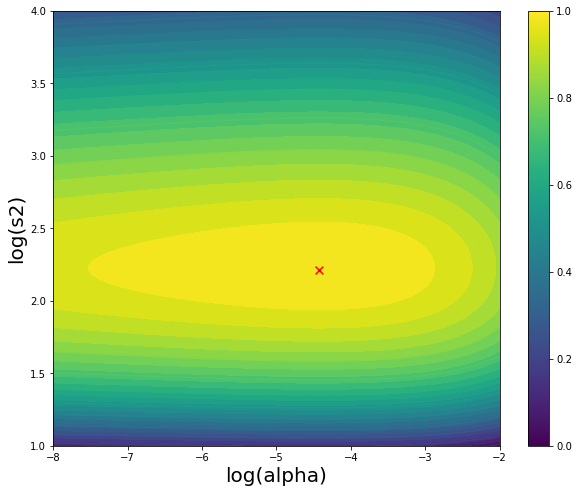

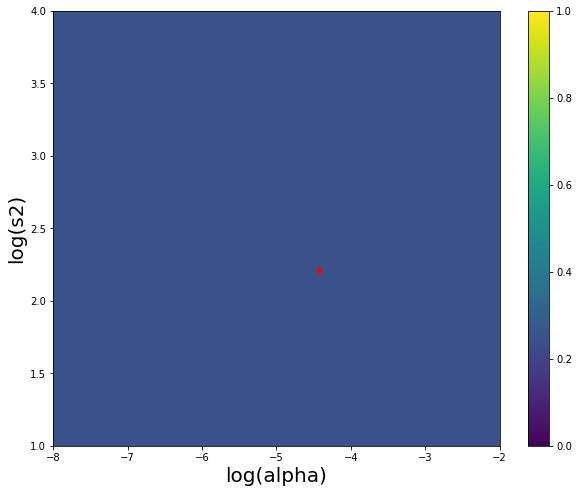

In [22]:
#### **** YOUR CODE HERE **** ####

#### Tasks 1b

#### Output should be the visualisation of p(alpha,r|y) and log p(alpha,r|y) in two separate figures. 
#plt.rcParams['figure.figsize'] = [20, 12]

X, Y= np.meshgrid(alpha_space, radius_space)

plt.contour(X,Y, logpy, levels = 10)
plt.scatter(alpha_space[np.argwhere(logpy==logpy.max())[0][1]],
            radius_space[np.argwhere(logpy==logpy.max())[0][0]], 
            color = 'red',
            s = 20)
#plt.colorbar()
plt.xlabel('log(alpha)', size = 20)
plt.ylabel('log(s2)', size = 20)

plt.contourf(X,Y, logpy, levels = 25)
plt.scatter(alpha_space[np.argwhere(logpy==logpy.max())[0][1]],
            radius_space[np.argwhere(logpy==logpy.max())[0][0]], 
            color = 'red',
            s = 60, marker = 'x')
plt.colorbar()
plt.xlabel('log(alpha)', size = 20)
plt.ylabel('log(s2)', size = 20)
plt.show()

X,Y = np.meshgrid(alpha_space, radius_space)

plt.contourf(X,Y, py, levels = 100)
plt.scatter(alpha_space[np.argwhere(logpy==logpy.max())[0][1]],
            radius_space[np.argwhere(logpy==logpy.max())[0][0]], 
            color = 'red',
            s = 20)
plt.colorbar()
plt.xlabel('log(alpha)', size = 20)
plt.ylabel('log(s2)', size = 20)
plt.show()

In [23]:
print('alpha = {:.10f}, s2 = {:.10f} with log probability = {:.10f}'.format(np.exp(alpha_space[np.argwhere(logpy==logpy.max())[0][1]]),
                                                                 np.exp(radius_space[np.argwhere(logpy==logpy.max())[0][0]]), 
                                                                 max(store_log_prob_y)))


alpha = 0.0119832861, s2 = 9.1350732839 with log probability = -1001.4669784956


In [24]:
alpha = 0.0119832861
s2 = 9.1350732839

Mu, SIGMA= compute_posterior(PHI_train, y_train, alph, s2)


y_post_train = PHI_train.dot(Mu)
y_post = PHI_test.dot(Mu)


var_matrix = np.diag(s2 + PHI_test.dot(SIGMA).dot(PHI_test.T))
upper_bound =  (y_post.reshape(384) + 1 * np.sqrt(var_matrix))
lower_bound =  (y_post.reshape(384) - 1 * np.sqrt(var_matrix))

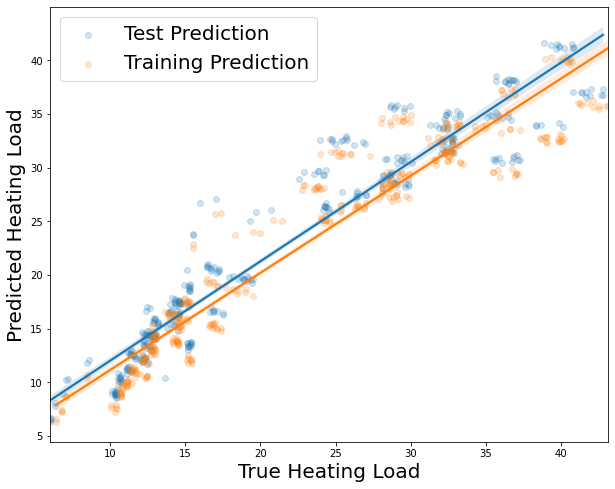

In [25]:
import seaborn as sns
sns.regplot(y_test,y_post, label = 'Test Prediction',scatter_kws={'alpha':0.2})
sns.regplot(y_train,y_post_train, label = 'Training Prediction',scatter_kws={'alpha':0.2})
plt.xlabel('True Heating Load', size = 20)
plt.ylabel('Predicted Heating Load', size = 20)
plt.legend(fontsize = 20)

In [26]:
r2(y_test,y_post), np.sqrt(MSE(y_test,y_post))

(0.9072833297521585, 3.0683537839646284)